# Experiments in Camera Alignment Using Image Encoding Comparisons

This notebook compiles a set of experiments in selecting the frame from an exploratory scan that best matches a fixed set of example target frames. In practice, the target frames are extracted from the beginnings of RUM training data, and aligning the camera to the best scan frame match should give the best possibility of RUM policy execution success.

In [21]:
import torch
import typing
from tqdm import tqdm

import video
import encoders
import visualizations

import torch.nn.functional as F

In [22]:
def average_cosine_similarity(frame_encoding: torch.Tensor, start_frame_encodings: torch.Tensor) -> float:
    x, y = start_frame_encodings, frame_encoding.unsqueeze(0).expand(start_frame_encodings.size(0), -1)
    similarity = F.cosine_similarity(x, y, dim=-1)
    return similarity.mean().item()


def max_cosine_similarity(frame_encoding: torch.Tensor, start_frame_encodings: torch.Tensor) -> float:
    x, y = start_frame_encodings, frame_encoding.unsqueeze(0).expand(start_frame_encodings.size(0), -1)
    similarity = F.cosine_similarity(x, y, dim=-1)
    return similarity.max().item()

In [23]:
def compute_alignment_scores(
    scan_frames: torch.Tensor,
    target_frames: torch.Tensor,
    encoder: typing.Callable[[torch.Tensor], torch.Tensor],
    compute_encoding_alignment_score: typing.Callable[[torch.Tensor, torch.Tensor], float],
    scan_frame_encodings_cache_path: str = None,
    target_frame_encodings_cache_path: str = None
):
    scan_frame_encodings = video.encode_frames(
        encoder,
        scan_frames,
        cache_path=scan_frame_encodings_cache_path,
        batch_size=32
    )
    target_frame_encodings = video.encode_frames(
        encoder,
        target_frames,
        cache_path=target_frame_encodings_cache_path,
        batch_size=32
    )

    alignment_scores = []
    for scan_frame in tqdm(scan_frame_encodings, desc='Comparing each scan frame to start frames'):
        alignment_scores.append(compute_encoding_alignment_score(scan_frame, target_frame_encodings))

    return alignment_scores

In [24]:
def run_experiment(
        encoder: typing.Callable[[torch.Tensor], torch.Tensor],
        similarity_scorer: typing.Callable[[torch.Tensor, torch.Tensor], float]
):
    """
    Runs an experiment where the similarity scorer is tested on all frames of a scan.
    
    :param encoder: Encodes images (B x C x H x W) into 1D encodings (B x D)
    :param similarity_scorer: Computes an aggregated similarity of one image encoding to a set of target frames
    """
    alignment_scores = compute_alignment_scores(
        scan_frames,
        start_frames,
        encoder,
        similarity_scorer,
        # scan_frame_encodings_cache_path='../cache/scan_frame_encodings.pt',
        # target_frame_encodings_cache_path='../cache/start_frame_encodings.pt'
    )

    visualizations.display_alignment_scores(alignment_scores)
    visualizations.display_most_aligned_frames(scan_frames, alignment_scores, top_k=20)

## Experiments

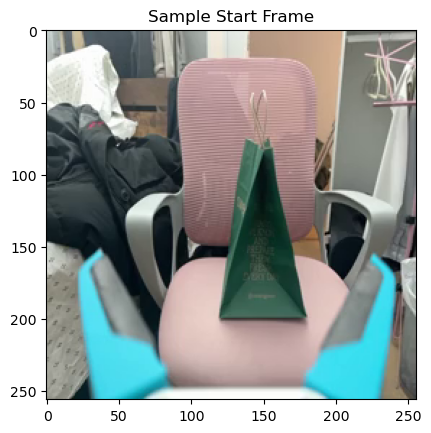

<Figure size 640x480 with 0 Axes>

In [25]:
device = 'cuda'
scan_frames = video.load_video_frames('../data/scan-over-bag-wide2.mp4', cache_path='../cache/scan_frames.pt').to(device)
start_frames = video.load_start_frames('../data/bag_pick_up_data', cache_path='../cache/start_frames.pt').to(device)

visualizations.display_frame(start_frames[80, :, :, :], title='Sample Start Frame')

Comparing each scan frame to start frames: 100%|██████████| 122/122 [00:00<00:00, 198.31it/s]


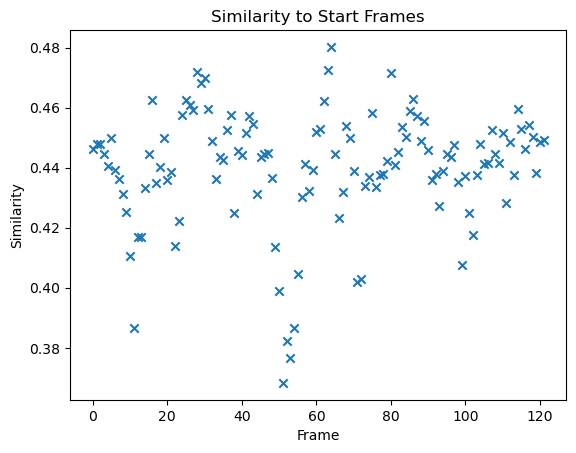

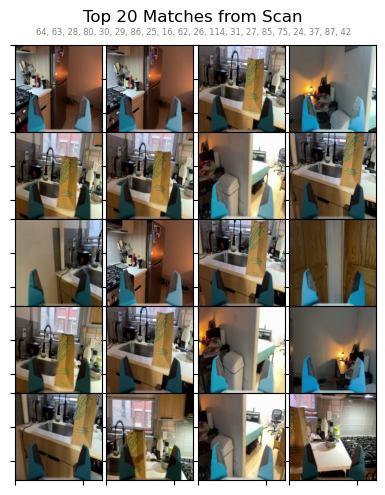

In [26]:
run_experiment(encoders.resnet_encoder(device), average_cosine_similarity)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Comparing each scan frame to start frames: 100%|██████████| 122/122 [00:00<00:00, 128.34it/s]


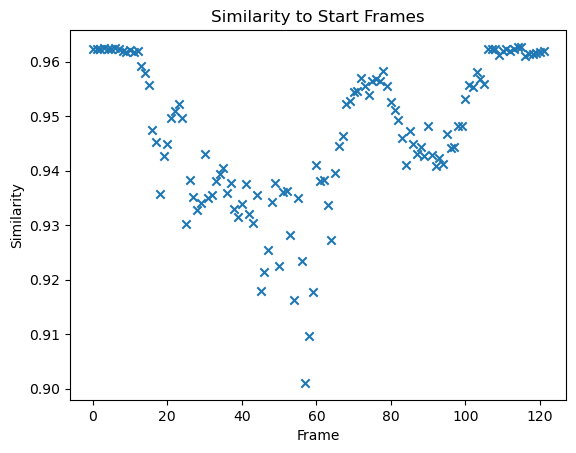

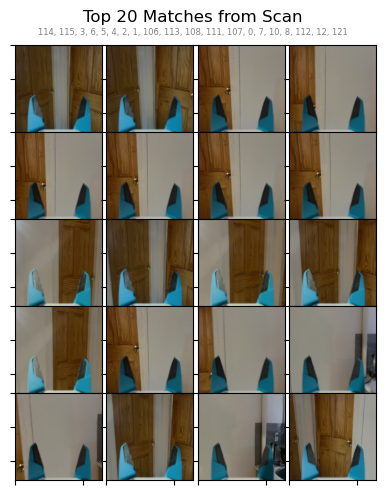

In [27]:
run_experiment(encoders.dino_hidden_state_encoder(device), average_cosine_similarity)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Comparing each scan frame to start frames: 100%|██████████| 122/122 [00:00<00:00, 5546.64it/s]


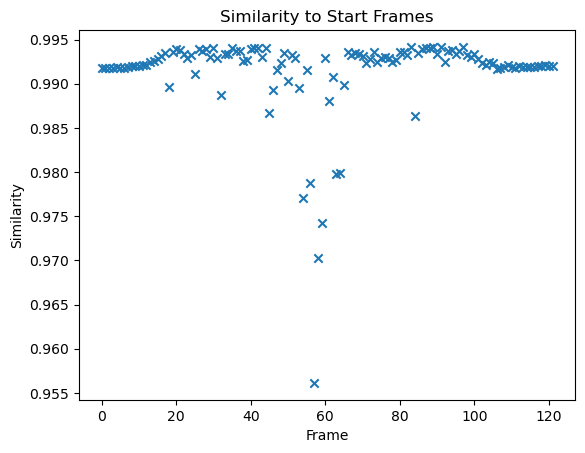

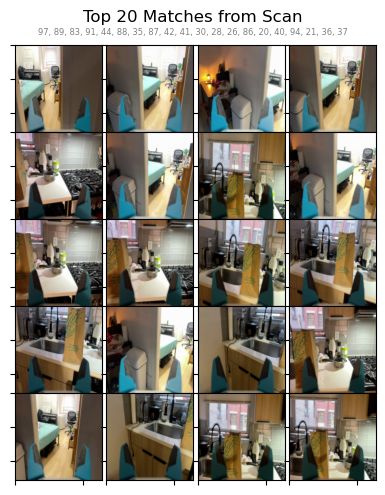

In [28]:
run_experiment(encoders.dino_cls_encoder(device), average_cosine_similarity)

Comparing each scan frame to start frames: 100%|██████████| 122/122 [00:00<00:00, 6254.42it/s]


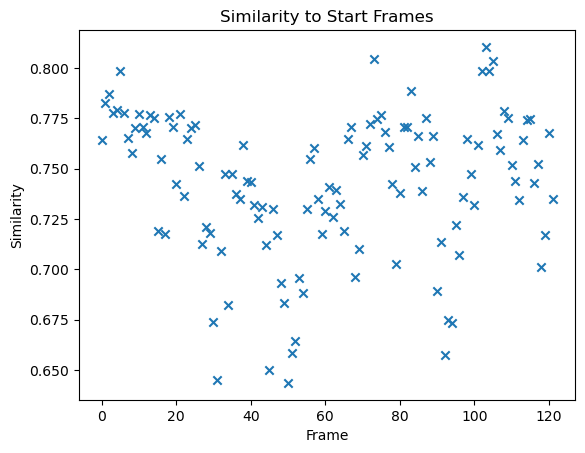

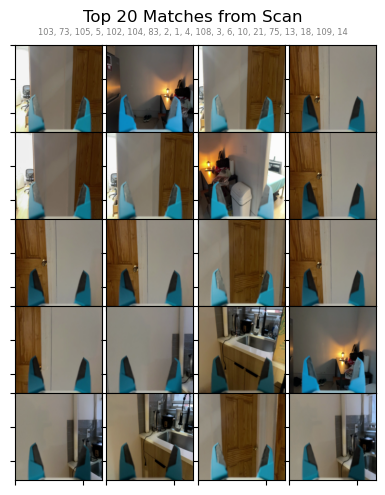

In [29]:
run_experiment(encoders.clip_encoder(device), average_cosine_similarity)